In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Let's visualize all channels in the dataset

In [2]:
# !pip install torchsummary

In [3]:
#IMPORTS
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import requests
from PIL import Image
import os
import io
import base64

In [4]:
import sys
sys.path.append(os.path.abspath("../../skin_cancer_nas")) # go to parent dir
sys.path.append(os.path.abspath("/mnt/skin_cancer_nas/data"))
sys.path.append(os.path.abspath("/mnt/skin_cancer_nas/data/torch_generator"))
sys.path.append(os.path.abspath("/mnt/skin_cancer_nas/nas/darts_torch"))

sys.path.append('/mnt')
sys.path.append('/mnt/skin_cancer_nas')
sys.path.append('/mnt/skin_cancer_nas/data/torch_generator')
from skin_cancer_nas.data.torch_generator import generator as data_gen
from skin_cancer_nas.data.torch_generator import base_classes
from skin_cancer_nas.data.torch_generator.config import *

from nas.darts_torch import *
# from config import CLASSES_SET
ROOT_PATHS = [  #Path('/mnt/data/interim/_melanoma_20200728/checkyourskin')]
                Path('/mnt/data/interim/_melanoma_20200728/loc')]
                #Path('/mnt/data/interim/_melanoma_20200728/loc_old_colored')]

CLASSES_SET = [ ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['c43'], class_name='C43', int_label=1), 
                ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['d22'], class_name='D22', int_label=0)]
classes_num = len(CLASSES_SET)
import cv2

In [5]:
import logging
logger = logging.getLogger('skin_cancer_nas__darts__attention_notebook')

In [6]:
# # Load model
device = 'cpu'

# model = torch.load("/mnt/models/darts_retrained_128x128_nonnorm_2lrs_16ch_d22-c43_aug1/epoch_8_model1.pt")
# model.to(device)
# for param in model.parameters():
#     param.requires_grad = False

### Data preparation

In [17]:
partition, labels = data_gen.train_val_split(val_ratio=0.1, classes_list=CLASSES_SET)

def get_input_output_from_path(sample_path, labels):
    '''
    Generates one sample of data
    '''
    try:
        # logger.info('Sample path={}'.format(sample_path))
        x_out = _convert_img_to_array(sample_path)
        x_out = x_out.astype('float32')
        x_out /= 255

        X = torch.as_tensor(x_out)
        y = labels[str(sample_path)]

        X = X.to(device)
        y = torch.tensor(y).to(device)
        return X, y
    except Exception as e:
        msg = 'Something went wrong at path={}, e={}'.format(sample_path, e)
        print(msg)
        logger.info(msg)

VALID_CHANNELS = ['r', 'ir', 'g', 'uv']
IMG_WIDTH = 128
IMG_HEIGHT = 128
VALUE_MISSING = 0
MISSING_CH_IMG = np.ones((IMG_HEIGHT, IMG_WIDTH)) * VALUE_MISSING
def _convert_img_to_array(sample_path):
    'Converts n grayscale images to 3D array with n channels'
    x_array = []
    for channel in VALID_CHANNELS:
        channel_path = os.path.join(sample_path, channel)
        if not os.path.exists(channel_path):
            x_array.append(MISSING_CH_IMG)
            continue
        image = os.listdir(channel_path)
        if not image:
            x_array.append(MISSING_CH_IMG)
            continue
        full_image_path = os.path.join(channel_path, image[0])
        img = img = cv2.imread(full_image_path, flags=cv2.IMREAD_GRAYSCALE)
        if img is None:
            x_array.append(MISSING_CH_IMG)
            continue
        else:
            shape = img.shape
            # logger.info(shape)
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)

        x_array.append(img)

    return np.stack(x_array, axis=0)

In [18]:
# labels

In [19]:
partition['validation'][0]

'/mnt/data/interim/_melanoma_20200728/loc/C43/2019-10-25_10-57-23'

! IMPORTANT ! - for now we don't have any image transformations (like normalization), but once they will be - they have to be added here!

In [20]:
X, y = get_input_output_from_path(sample_path=partition['validation'][0], labels=labels)
# X.requires_grad_()

### Gallery

In [21]:
class FlowLayout(object):
    ''' A class / object to display plots in a horizontal / flow layout below a cell '''
    def __init__(self):
        # string buffer for the HTML: initially some CSS; images to be appended
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        margin: 10px;
        border: 3px solid #888888;  
        }
        </style>
        """

    def add_plot(self, oAxes):
        ''' Saves a PNG representation of a Matplotlib Axes object '''
        Bio=io.BytesIO() # bytes buffer for the plot
        fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) # make a png of the plot in the buffer

        # encode the bytes as string using base 64 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            '</div>')

    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))

In [22]:
def display_gallery(X_list, y_list, paths_list):
    
    assert len(X_list) == len(y_list)
    assert len(X_list) == len(paths_list)
    
    full_list = zip(X_list, y_list, paths_list)
    
    def display_zipped_list(zipped_list):
        for X, y, path in tqdm(zipped_list):

            path = path.replace('/mnt/data/interim/_melanoma_20200728', '')

            # Display image channels ##################################################################
            for i in range(4):  #we have 4 channels
                fig, ax1 = plt.subplots(1, 1, figsize=fig_size)
                ax1.imshow(X[i], cmap=plt.cm.gray)
                ax1.title.set_text('true_y={}, channel={}, \n{}, '.format(y, i, path))
                oPlot.add_plot(ax1) # pass it to the FlowLayout to save as an image
                plt.close()

        oPlot.PassHtmlToCell()
    
    oPlot = FlowLayout() # create an empty FlowLayout
    fig_size = (4,4)
#     print(len(full_list))
    display_zipped_list(full_list)

    

In [23]:
# Gather list of input 'image' matrices, labels and paths (for titles)
X_list = []
y_list = []  # y_true
paths_list = []
saliencies_list = []
score_max_index_list = []  # y_pred
len_val = len(partition['validation'])
print(len_val)
for i in tqdm(range(len_val)):
    sample_path = partition['validation'][i]
    _X, _y = get_input_output_from_path(sample_path=sample_path, labels=labels)
    X_list.append(_X)
    y_list.append(_y)
    paths_list.append(sample_path)
    
#     saliencies, score_max_index = get_saliencies(_X, model, classes_num=classes_num)
#     saliencies_list.append(saliencies)
#     score_max_index_list.append(score_max_index)

14



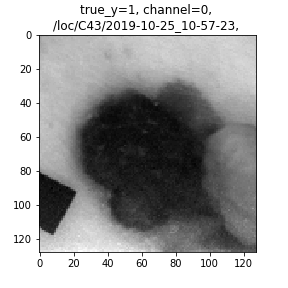
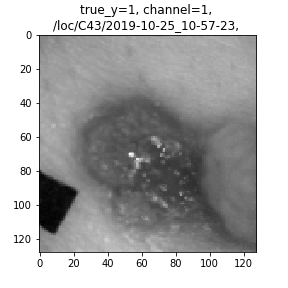
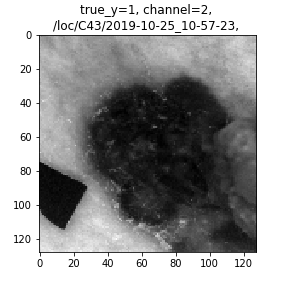
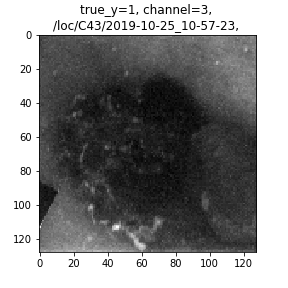
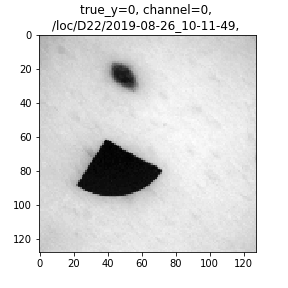
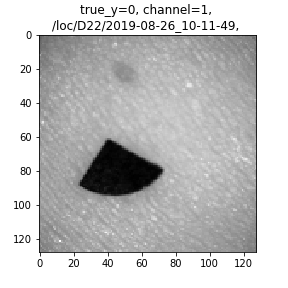
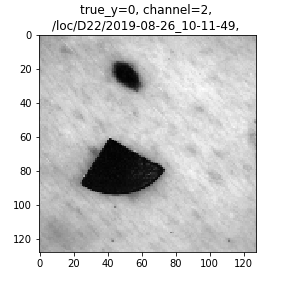
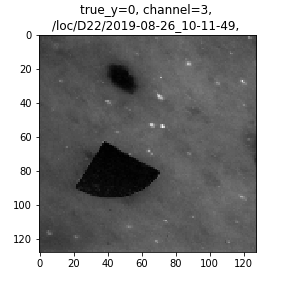
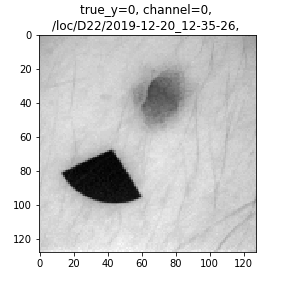
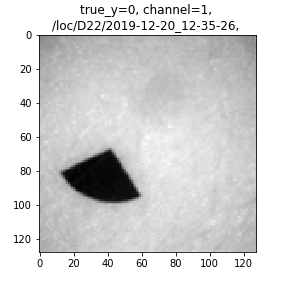
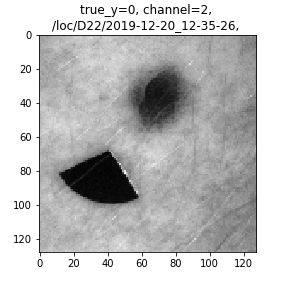
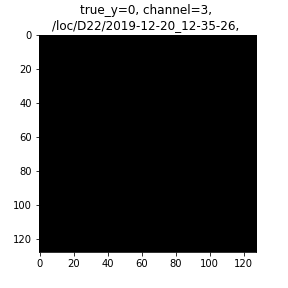
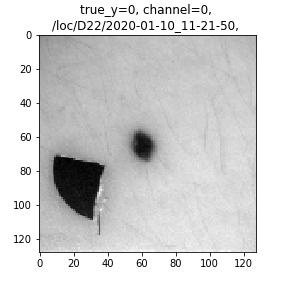
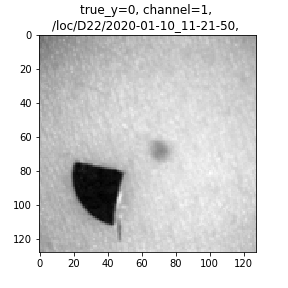
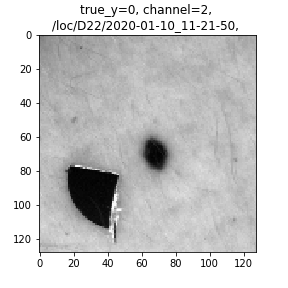
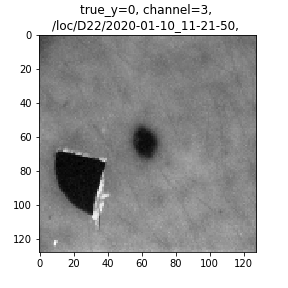
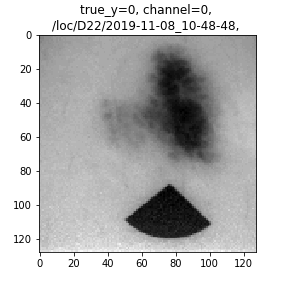
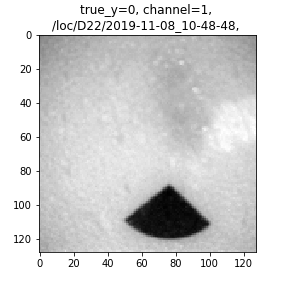
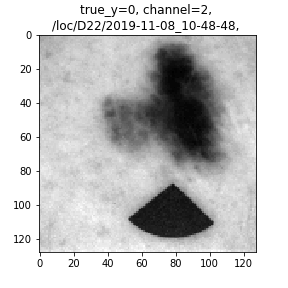
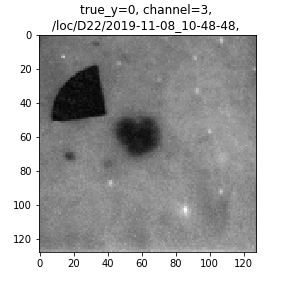
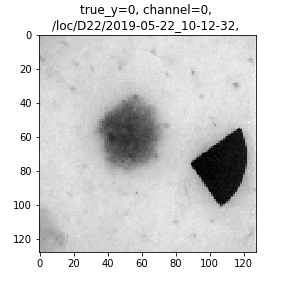
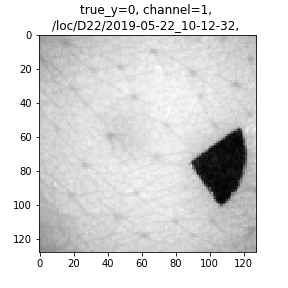
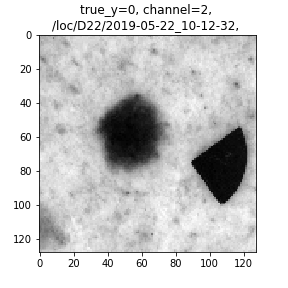
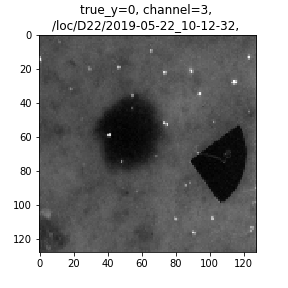
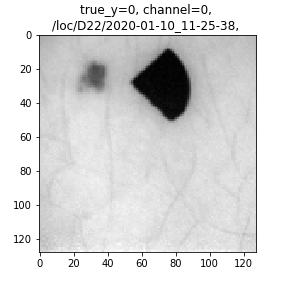
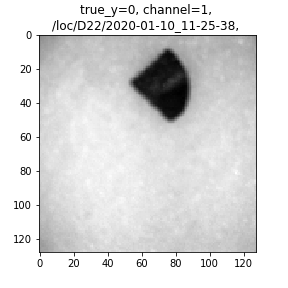
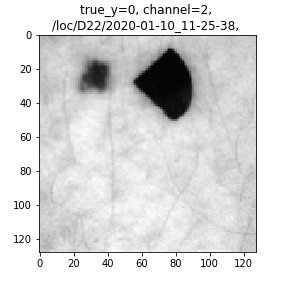
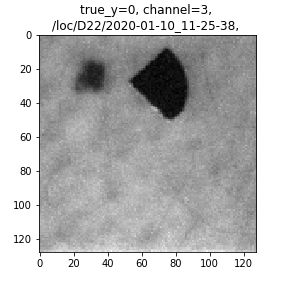
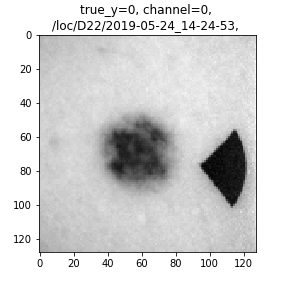
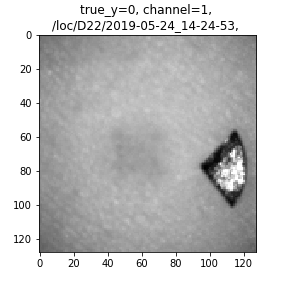
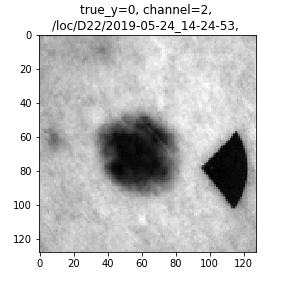
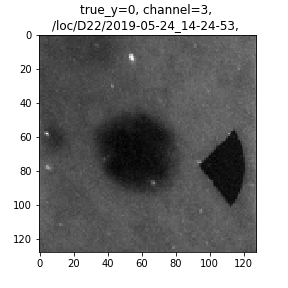
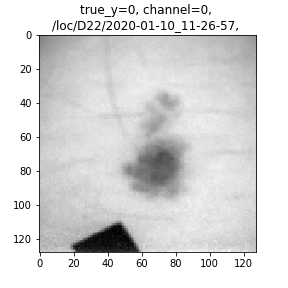
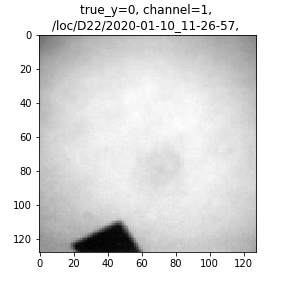
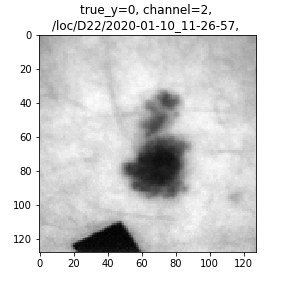
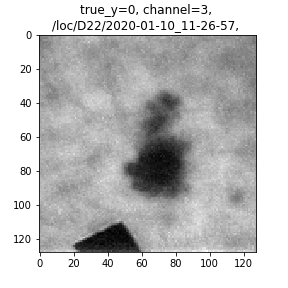
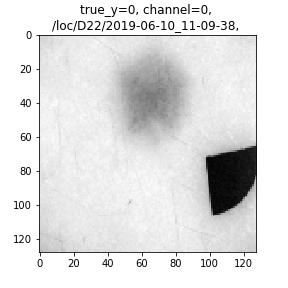
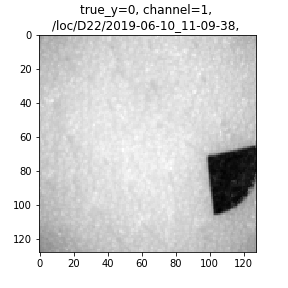
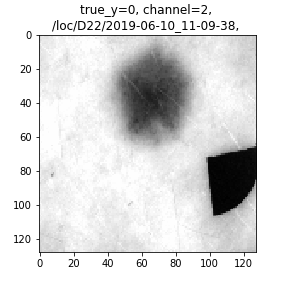
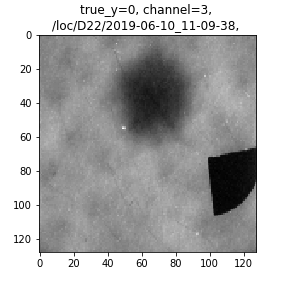
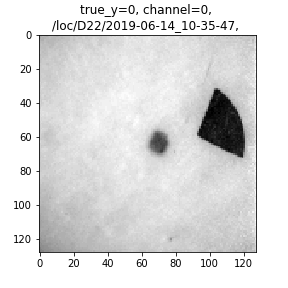
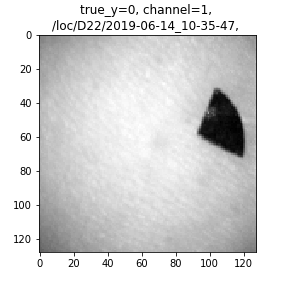
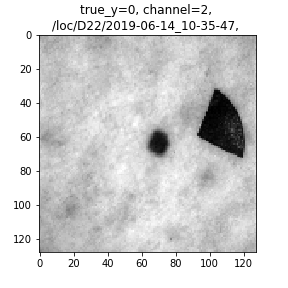
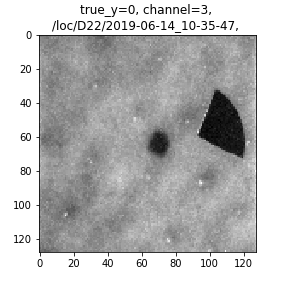
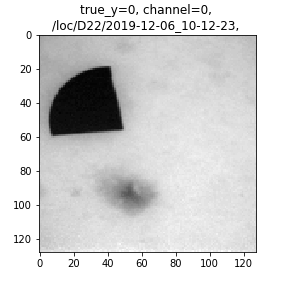
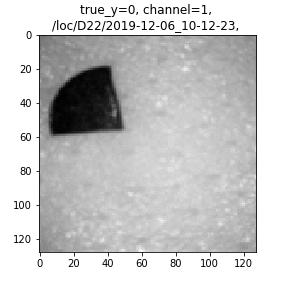
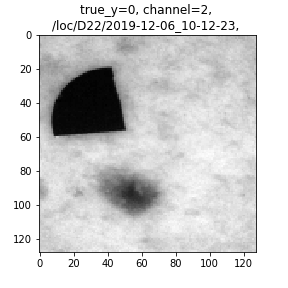
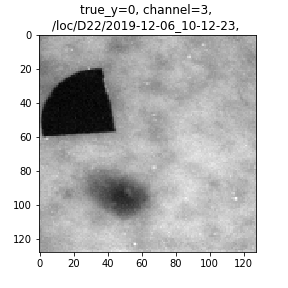
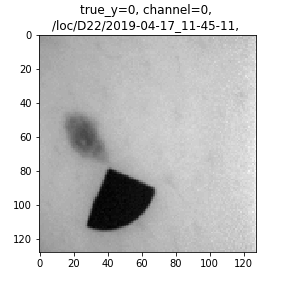
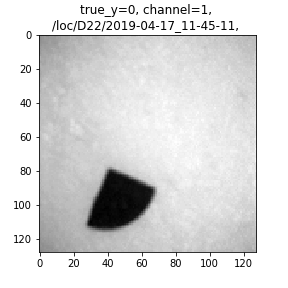
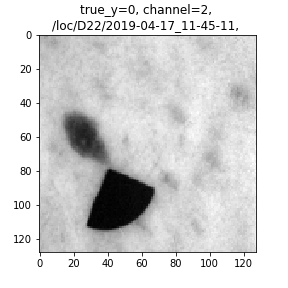
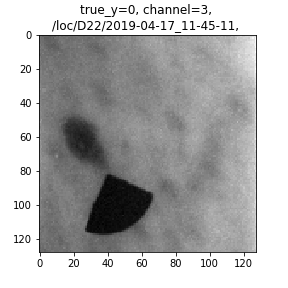
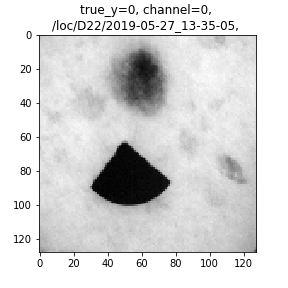
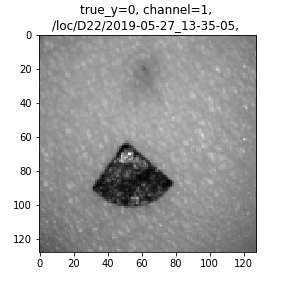
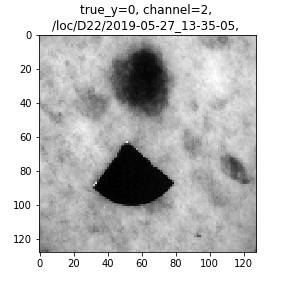
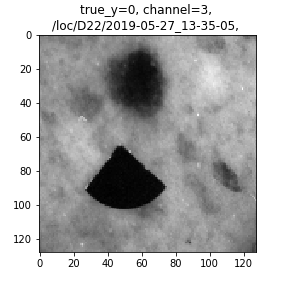

In [24]:
# Firstly 4 channels, then 4 channels of saliency map for winning class (which might be wrong! - check true_y Vs pred_y !)
display_gallery(X_list, y_list, paths_list)